In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def read_and_clean_dataset(variable_name):
    """
    Upload and clean a dataset by dropping longitude and latitude columns.
    
    Parameters:
    - variable_name (str): input variable called in the input file name
    
    Returns:
    - pd.DataFrame: Cleaned DataFrame with time and RH columns only.
    """
    # Load the dataset
    df = pd.read_csv('../../data/input_synthetic_dataset/'+variable_name+'_Tuddal_2019.csv',parse_dates=['time'], dayfirst=True)
    
    # Drop the longitude and latitude columns
    df = df.drop(columns=['longitude', 'latitude'])
    
    # Reset index for the cleaned DataFrame
    df = df.reset_index(drop=True)
    
    return df

# Load the datasets
snowf_data = read_and_clean_dataset('Snowf')
precip_data = read_and_clean_dataset('total_precipitation')
rainf_data = read_and_clean_dataset('Rainf')
RH_data = read_and_clean_dataset('RH')
T_air_data = read_and_clean_dataset('Tair')


# Ensure all data has a consistent datetime index
for df in [snowf_data, precip_data, rainf_data, RH_data,T_air_data]:
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

# Merge all datasets on date (specific to this column names)
data = pd.DataFrame(index=precip_data.index)
data['total_precipitation'] = precip_data['total_precipitation']
data['Rainf'] = rainf_data['Rainf']
data['Snowf'] = snowf_data['Snowf']
data['RH'] = RH_data['RH']
data['Tair'] = T_air_data['Tair']

def snow_accumulation(data):
    
    # Convert snowfall rate to snow cover (kg/m² to mm of snow equivalent)
    data['snow_fall'] = data['Snowf'] * 3600 #mm

    # Calculate cumulative snow cover over time
    data['cumulative_snow_cover'] = data['snow_fall'].cumsum()

    return data

snow_cover_data = snow_accumulation(data)
#snow_cover_data

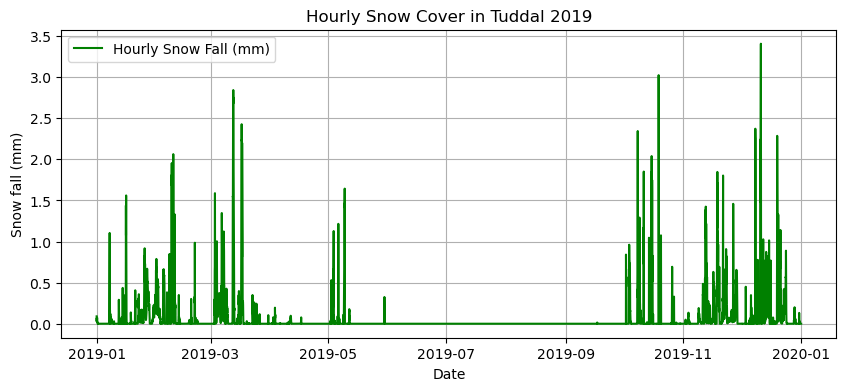

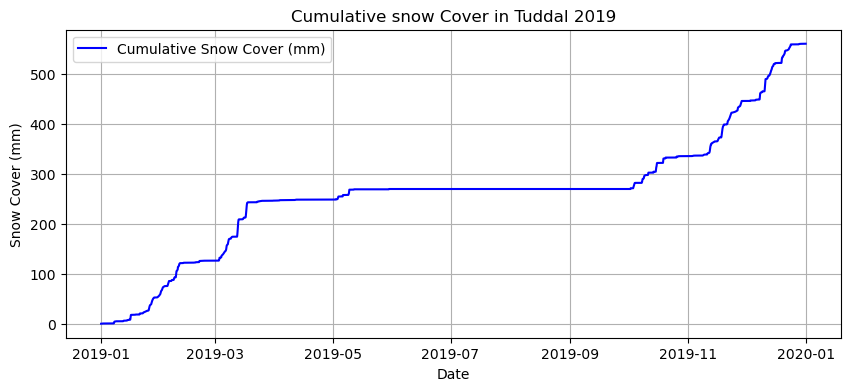

In [2]:
plt.figure(figsize=(10, 4))
plt.plot(snow_cover_data.index, snow_cover_data['snow_fall'], label='Hourly Snow Fall (mm)', color='green')
plt.xlabel('Date')
plt.ylabel('Snow fall (mm)')
plt.title('Hourly Snow Cover in Tuddal 2019')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(snow_cover_data.index, snow_cover_data['cumulative_snow_cover'], label='Cumulative Snow Cover (mm)', color='blue')
plt.xlabel('Date')
plt.ylabel('Snow Cover (mm)')
plt.title('Cumulative snow Cover in Tuddal 2019')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
#plt.plot(snow_cover_data.index, snow_cover_data['Tair'])

In [4]:
import numpy as np

def snow_melt_model(T_air, RH, rainfall, time_step_hours=1):
    """
    Calculate snow melt based on air temperature, relative humidity, and rainfall.
    
    Parameters:
    - T_air: Air temperature (K)
    - RH: Relative humidity (0-1)
    - rainfall: Rainfall rate (kg/m²/s)
    - time_step_hours: Time step of the simulation (hours)
    
    Returns:
    - total_melt: Total amount of snow melted (mm) for the given time step
    """
    # Constants
    C_m = 0.125  # Degree-hour factor (mm/°C/hour), adjusted from daily factor
    C_h = 0.1 / 24  # Humidity factor (mm/mb/hour), adjusted from daily factor
    T_b = 273.15  # Base temperature (0°C in K)

    # Convert units
    T_a = T_air - 273.15  # Convert K to °C
    P_r = rainfall * 3600 * time_step_hours  # Convert kg/m²/s to mm for the time step

    # Temperature-induced melt
    M_T = max(0, C_m * (T_a - (T_b - 273.15)) * time_step_hours)

    # Rain-induced melt
    M_R = 0.0125 * T_a * P_r

    # Humidity-induced melt
    e_s = 6.11  # Saturation vapor pressure at the snow surface (mb)
    e_a = RH * 6.11 * np.exp((17.27 * T_a) / (T_a + 237.3))  # Actual vapor pressure of the air (mb)
    M_H = C_h * (e_a - e_s) * time_step_hours

    # Total melt
    total_melt = max(0, M_T + M_R + M_H)

    return total_melt, M_T, M_R, M_H

In [5]:
# Prepare lists to store results
#snow_cover_list = [data['cumulative_snow_cover'].iloc[0]]
melt_list = []; M_T_list = []; M_R_list = []; M_H_list = []

# Run the snow melt model for each time step
for i in range(len(data)):
    
    total_melt, M_T, M_R, M_H = snow_melt_model(data.iloc[i]['Tair'], data.iloc[i]['RH'], data.iloc[i]['Rainf'])
    melt_list.append(total_melt)
    M_T_list.append(M_T)
    M_R_list.append(M_R)
    M_H_list.append(M_H)

# Add results to the dataframe
#data['modeled_snow_cover'] = snow_cover_list[1:]  # Exclude initial snow cover
data['total_melt'] = melt_list
data['cumulative_melt'] = data['total_melt'].cumsum()


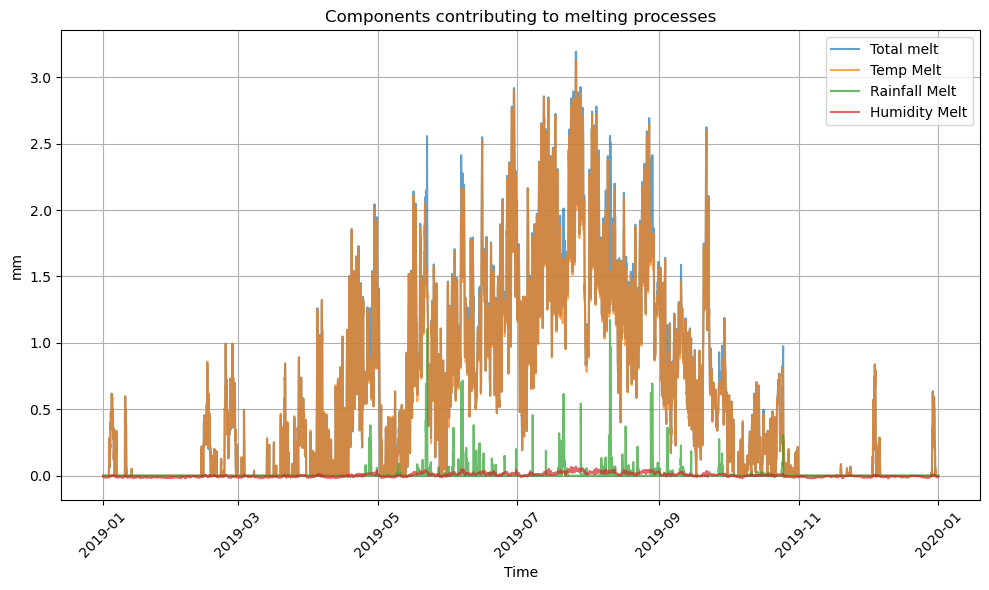

In [6]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['total_melt'], label='Total melt', alpha=0.7)
plt.plot(data.index, M_T_list, label='Temp Melt', alpha=0.7)
plt.plot(data.index, M_R_list, label='Rainfall Melt', alpha=0.7)
plt.plot(data.index, M_H_list, label='Humidity Melt', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Components contributing to melting processes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

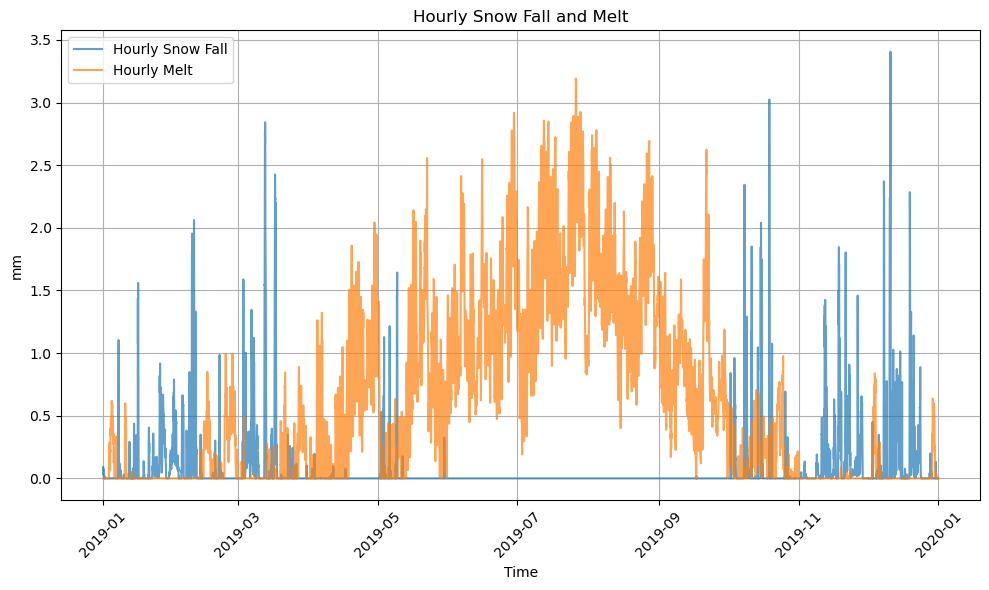

In [7]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['snow_fall'], label='Hourly Snow Fall', alpha=0.7)
plt.plot(data.index, data['total_melt'], label='Hourly Melt', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Hourly Snow Fall and Melt')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

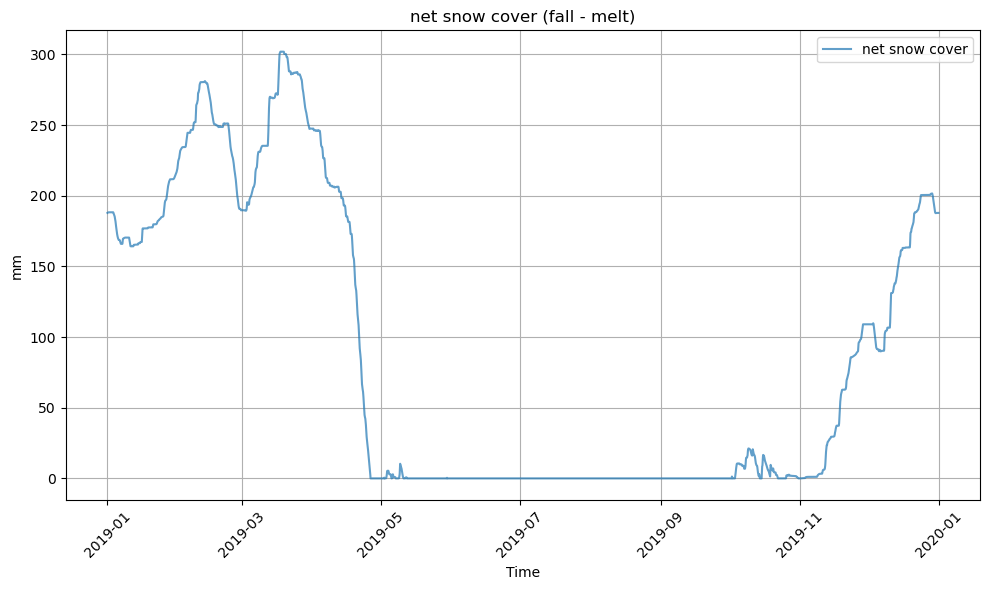

In [8]:
#data['net_snow_cover'] = data['cumulative_snow_cover']
net_snow_cover_list = [187.8086287842404] #[data['cumulative_snow_cover'].iloc[0]]
# I set manually the initial value (running the code from initial value = 0)

for i in range(1,len(data)):
    net_snow_cover = data['snow_fall'].iloc[i] - data['total_melt'].iloc[i]
    net_snow_cover_acc = max(0,net_snow_cover_list[-1] + net_snow_cover)
    net_snow_cover_list.append(net_snow_cover_acc)

data['net_snow_cover'] = net_snow_cover_list

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, net_snow_cover_list, label='net snow cover', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('net snow cover (fall - melt)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
data.to_csv('data.csv', index=False)
data

,total_precipitation,Rainf,Snowf,RH,Tair,snow_fall,cumulative_snow_cover,total_melt,cumulative_melt,net_snow_cover
time,,,,,,,,,,
2019-01-01 00:00:00,2.494830e-05,0.0,2.494830e-05,0.819464,271.94138,8.981387e-02,0.089814,0.0,0.000000,187.808629
2019-01-01 01:00:00,7.502958e-06,0.0,7.502958e-06,0.813590,272.01923,2.701065e-02,0.116825,0.0,0.000000,187.835639
2019-01-01 02:00:00,1.941385e-05,0.0,1.941385e-05,0.790778,272.19520,6.988985e-02,0.186714,0.0,0.000000,187.905529
2019-01-01 03:00:00,1.661509e-05,0.0,1.661509e-05,0.754080,272.56476,5.981433e-02,0.246529,0.0,0.000000,187.965344
2019-01-01 04:00:00,8.726317e-06,0.0,8.726317e-06,0.702231,272.64880,3.141474e-02,0.277943,0.0,0.000000,187.996758
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.000000e+00,0.0,0.000000e+00,0.758873,272.52180,0.000000e+00,559.765504,0.0,5045.407241,187.808627
2019-12-31 20:00:00,0.000000e+00,0.0,0.000000e+00,0.784675,272.46268,0.000000e+00,559.765504,0.0,5045.407241,187.808627
2019-12-31 21:00:00,9.044843e-11,0.0,9.044843e-11,0.801337,272.93790,3.256143e-07,559.765505,0.0,5045.407241,187.808628


In [10]:
net_snow_cover_list[-1]

187.8086287842404

In [11]:
import numpy as np

def snow_cover_fraction(snow_depth, complete_cover_threshold=100):
    """
    Estimate snow cover fraction from snow depth.
    
    Parameters:
    - snow_depth: Net amount of snow on the ground (mm)
    - complete_cover_threshold: Snow depth at which the cover is considered complete (mm)
    
    Returns:
    - fraction: Estimated snow cover fraction [0-1]
    """
    # Logistic function parameters
    k = 0.05  # Steepness of the curve
    x0 = complete_cover_threshold / 2  # Midpoint of the curve
    
    # Calculate snow cover fraction using a logistic function
    fraction = 1 / (1 + np.exp(-k * (snow_depth - x0)))
    
    return fraction

# Example usage
snow_depths = [0, 10, 50, 100, 150, 200]
for depth in snow_depths:
    fraction = snow_cover_fraction(depth)
    print(f"Snow depth: {depth} mm, Snow cover fraction: {fraction:.3f}")

# If you have a time series, you can apply this to your entire dataset
# Assuming your time series is stored in a variable called 'snow_depth_timeseries'
# snow_fraction_timeseries = [snow_cover_fraction(depth) for depth in snow_depth_timeseries]

Snow depth: 0 mm, Snow cover fraction: 0.076
Snow depth: 10 mm, Snow cover fraction: 0.119
Snow depth: 50 mm, Snow cover fraction: 0.500
Snow depth: 100 mm, Snow cover fraction: 0.924
Snow depth: 150 mm, Snow cover fraction: 0.993
Snow depth: 200 mm, Snow cover fraction: 0.999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


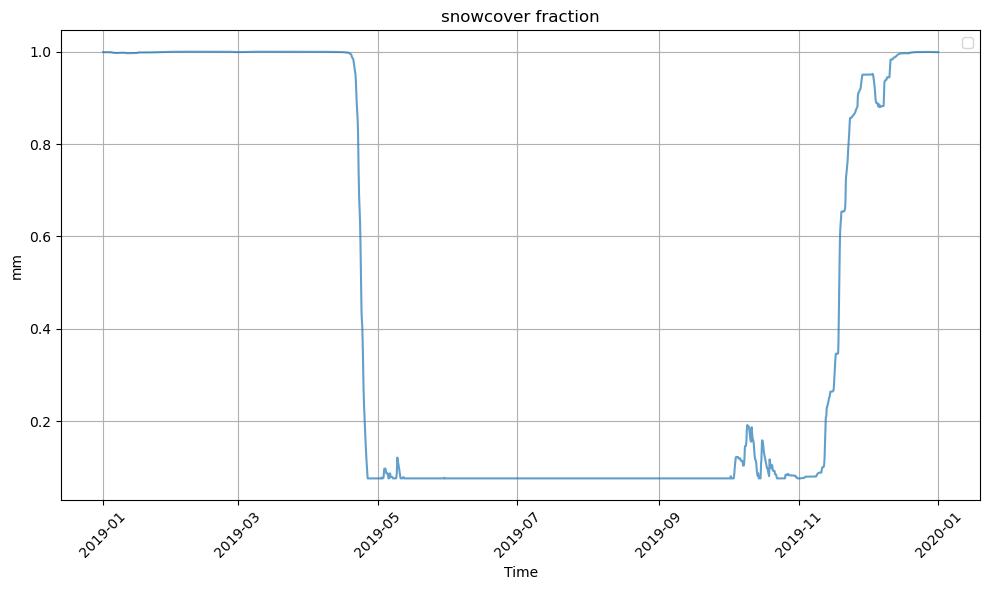

In [12]:
snow_cover_fraction = snow_cover_fraction(data['net_snow_cover'], complete_cover_threshold=100)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, snow_cover_fraction, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('snowcover fraction')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:

df = snow_cover_fraction.reset_index()  # Converts the Series into a DataFrame with 'time' as a column
# Rename the columns
df.columns = ['time', 'Snow Cover Fraction']
df.to_csv("../../data/postprocessed_synthetic_dataset/snow_cover_fraction_2019_postprocessed.csv")# index=False)

## Old code

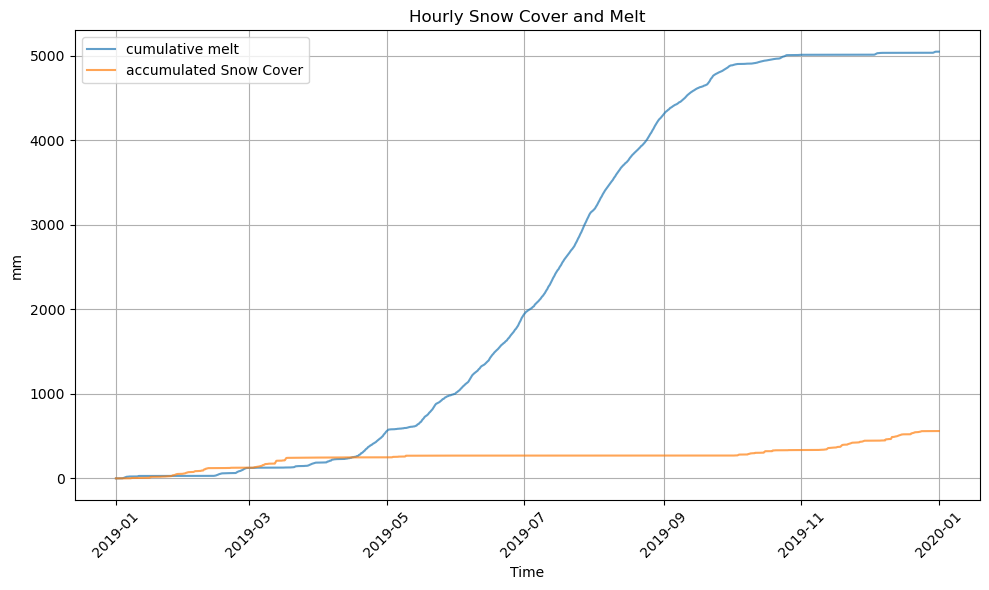

In [86]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['cumulative_melt'], label='cumulative melt', alpha=0.7)
plt.plot(data.index, data['cumulative_snow_cover'], label='accumulated Snow Cover', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Hourly Snow Cover and Melt')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
data.to_csv('data.csv', index=False)

In [18]:
data['cumulative_snow_cover'].iloc[0]

0.0898138728

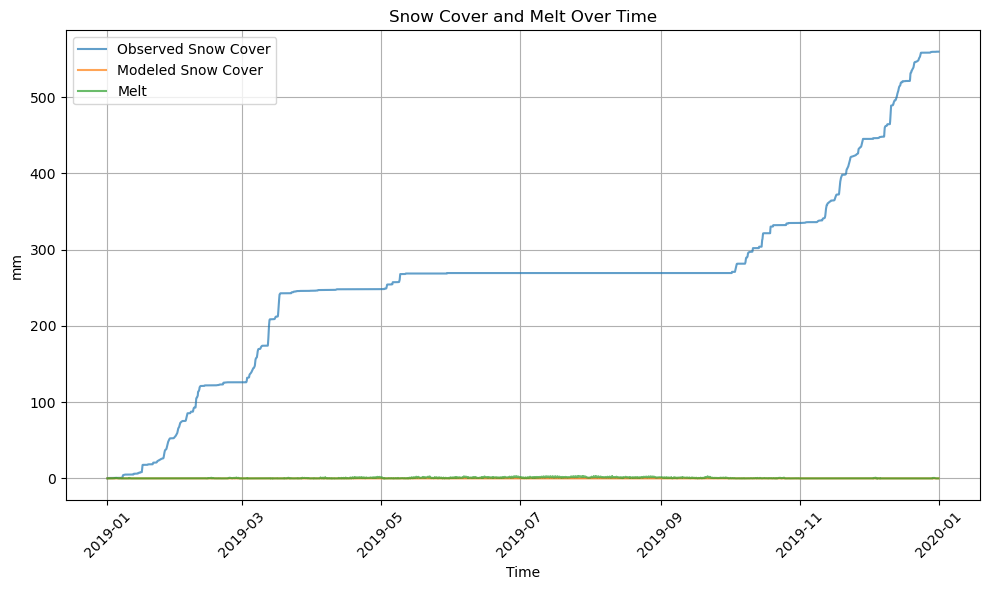

In [219]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['cumulative_snow_cover'], label='Observed Snow Cover', alpha=0.7)
plt.plot(data.index, data['modeled_snow_cover'], label='Modeled Snow Cover', alpha=0.7)
plt.plot(data.index, data['melt'], label='Melt', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Snow Cover and Melt Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [124]:
data

,total_precipitation,Rainf,Snowf,RH,Tair,time_delta,snow_cover,cumulative_snow_cover,modeled_snow_cover,melt
time,,,,,,,,,,
2019-01-01 00:00:00,2.494830e-05,0.0,2.494830e-05,0.819464,271.94138,0.0,0.000000e+00,0.000000,0.0,0.0
2019-01-01 01:00:00,7.502958e-06,0.0,7.502958e-06,0.813590,272.01923,3600.0,2.701065e-02,0.027011,0.0,0.0
2019-01-01 02:00:00,1.941385e-05,0.0,1.941385e-05,0.790778,272.19520,3600.0,6.988985e-02,0.096900,0.0,0.0
2019-01-01 03:00:00,1.661509e-05,0.0,1.661509e-05,0.754080,272.56476,3600.0,5.981433e-02,0.156715,0.0,0.0
2019-01-01 04:00:00,8.726317e-06,0.0,8.726317e-06,0.702231,272.64880,3600.0,3.141474e-02,0.188130,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.000000e+00,0.0,0.000000e+00,0.758873,272.52180,3600.0,0.000000e+00,559.675690,0.0,0.0
2019-12-31 20:00:00,0.000000e+00,0.0,0.000000e+00,0.784675,272.46268,3600.0,0.000000e+00,559.675690,0.0,0.0
2019-12-31 21:00:00,9.044843e-11,0.0,9.044843e-11,0.801337,272.93790,3600.0,3.256143e-07,559.675691,0.0,0.0


In [11]:
# Reset index to make 'time' a regular column
data = data.reset_index()

# Prepare lists to store results
snow_cover_list = [data['cumulative_snow_cover'].iloc[0]]
melt_list = []

# Run the snow melt model for each time step
for i in range(len(data)):
    if i == 0:
        time_step_hours = 1  # Assume 1 hour for the first step
    else:
        time_step_hours = (data.iloc[i]['time'] - data.iloc[i-1]['time']).total_seconds() / 3600
    
    melt, new_snow_cover = snow_melt_model(
        snow_cover_list[-1],
        data.iloc[i]['Tair'],
        data.iloc[i]['RH'],
        data.iloc[i]['Rainf'],
        time_step_hours
    )
    
    snow_cover_list.append(new_snow_cover)
    melt_list.append(melt)

# Add results to the dataframe
data['modeled_snow_cover'] = snow_cover_list[1:]  # Exclude initial snow cover
data['melt'] = melt_list

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(data['time'], data['cumulative_snow_cover'], label='Observed Snow Cover', alpha=0.7)
plt.plot(data['time'], data['modeled_snow_cover'], label='Modeled Snow Cover', alpha=0.7)
plt.plot(data['time'], data['melt'], label='Melt', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Snow Cover and Melt Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

In [74]:
def snow_accumulation(snowf_data, precip_data, rainf_data):

    # Ensure all data has a consistent datetime format
    for df in [snowf_data, precip_data, rainf_data]:
        df['time'] = pd.to_datetime(df['time'])
    
    # Merge all datasets on the 'time' column
    data = precip_data[['time', 'total_precipitation']].copy()
    data = data.merge(rainf_data[['time', 'Rainf']], on='time', how='left')
    data = data.merge(snowf_data[['time', 'Snowf']], on='time', how='left')
    
    # Calculate time delta in seconds between data points
    data['time_delta'] = data['time'].diff().dt.total_seconds().fillna(0)
    
    # Convert snowfall rate to snow cover (kg/m² to mm of snow equivalent)
    data['snow_cover'] = data['Snowf'] * data['time_delta'] * 1000 / 1000  # Convert to mm
    
    # Calculate cumulative snow cover over time
    data['cumulative_snow_cover'] = data['snow_cover'].cumsum()

    return data

# Example usage
data = snow_accumulation(snowf_data, precip_data, rainf_data)
print(data)

KeyError: 'time'

In [72]:
import numpy as np

def snow_melt_model(snow_cover, T_air, RH_air, rainfall_rate, time_step_hours):
    """
    Calculate snow melt based on air temperature, relative humidity, and rainfall rate.
    
    Parameters:
    - snow_cover: Current snow water equivalent (mm)
    - T_air: Air temperature (°C)
    - RH_air: Relative humidity (%)
    - rainfall_rate: Rainfall rate (mm/hour)
    - time_step_hours: Time step of the simulation (hours)
    
    Returns:
    - melt: Amount of snow melted (mm)
    - updated_snow_cover: Updated snow water equivalent (mm)
    """
    # Constants
    T_base = 0  # Base temperature for melting (°C)
    C_m = 0.125  # Degree-day factor (mm/°C/hour); adjusted for hourly
    RH_factor = 0.05  # Factor for humidity effect
    rain_factor = 0.0125  # Factor for rain-on-snow effect (mm⁻¹)
    
    # Temperature-based melt (degree-day method)
    temp_melt = max(0, C_m * (T_air - T_base) * time_step_hours)  # Adjusted for hours
    
    # Humidity effect
    humidity_melt = temp_melt * (1 + RH_factor * (RH_air - 50))  # Increased melt for RH > 50%
    
    # Rain-on-snow effect
    rain_melt = rainfall_rate * rain_factor * time_step_hours  # Adjusted for hours
    
    # Total melt
    total_melt = humidity_melt + rain_melt
    
    # Ensure melt doesn't exceed available snow
    melt = min(total_melt, snow_cover)
    
    # Update snow cover
    updated_snow_cover = snow_cover - melt
    
    return melt, updated_snow_cover

# Example usage
initial_snow_cover = 100  # mm
T_air = 5  # °C
RH_air = 70  # %
rainfall_rate = 10  # mm/hour
time_step_hours = 1  # hour

melt, new_snow_cover = snow_melt_model(initial_snow_cover, T_air, RH_air, rainfall_rate, time_step_hours)

print(f"Snow melt: {melt:.2f} mm")
print(f"Updated snow cover: {new_snow_cover:.2f} mm")

Snow melt: 1.38 mm
Updated snow cover: 98.62 mm


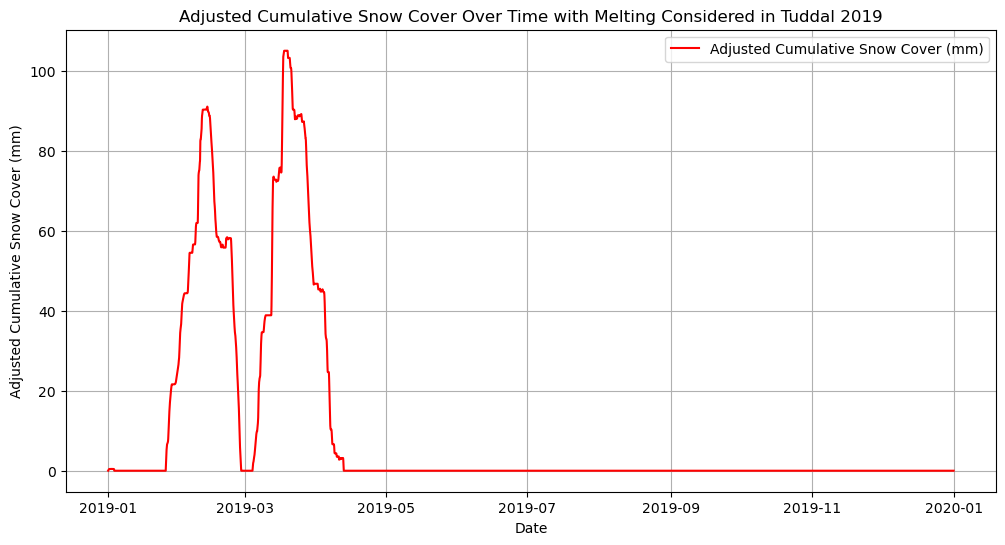

In [81]:
# Load the temperature and humidity datasets
temp_data = pd.read_csv('../../data/input_synthetic_dataset/Tair_Tuddal_2019.csv')
rh_data = pd.read_csv('../../data/input_synthetic_dataset/RH_Tuddal_2019.csv')

# Ensure consistent datetime index
temp_data['time'] = pd.to_datetime(temp_data['time'])
rh_data['time'] = pd.to_datetime(rh_data['time'])
temp_data.set_index('time', inplace=True)
rh_data.set_index('time', inplace=True)

# Add temperature and humidity to the main data frame
data['temperature'] = temp_data['Tair']
data['humidity'] = rh_data['RH']

# Define parameters for melting
melting_temp_threshold = 273  # Melting occurs above 0°C
degree_day_factor = 3.0  # Melting rate in mm/°C/day, for simplicity
rain_melting_factor = 0.5  # Rain contributes directly to melting

# Calculate melting rate
# Melting from temperature (only when temperature > 0°C)
data['temp_melt'] = data.apply(
    lambda row: max(row['temperature'] - melting_temp_threshold, 0) * row['time_delta'] / 86400 * degree_day_factor, axis=1
)

# Melting from rain (assuming rain contributes directly to melting)
data['rain_melt'] = data['Rainf'] * data['time_delta'] * rain_melting_factor

# Total melt
data['total_melt'] = data['temp_melt'] + data['rain_melt']

# Adjust cumulative snow cover by subtracting melt
data['adjusted_cumulative_snow_cover'] = (data['cumulative_snow_cover'] - data['total_melt'].cumsum()).clip(lower=0)

# Plotting the adjusted cumulative snow cover
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['adjusted_cumulative_snow_cover'], label='Adjusted Cumulative Snow Cover (mm)', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Cumulative Snow Cover (mm)')
plt.title('Adjusted Cumulative Snow Cover Over Time with Melting Considered in Tuddal 2019')
plt.legend()
plt.grid(True)
plt.show()


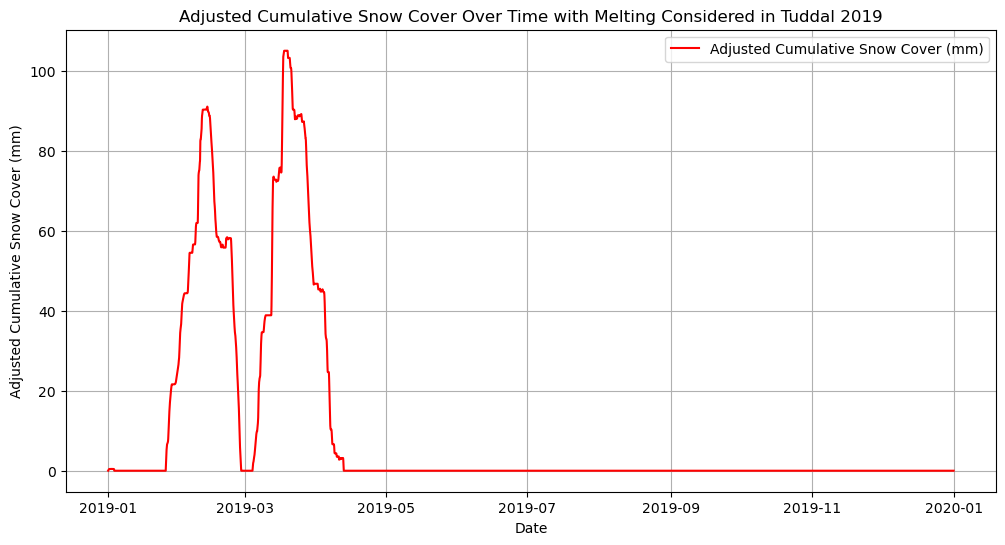

In [33]:
# Define parameters for melting
melting_temp_threshold = 273.0  # Melting occurs above 0°C
degree_day_factor = 3.0  # Melting rate in mm/°C/day, for simplicity
rain_melting_factor = 0.5  # Rain contributes directly to melting

# Calculate melting rate
# Melting from temperature (only when temperature > 0°C)
data['temp_melt'] = data.apply(
    lambda row: max(row['Tair'] - melting_temp_threshold, 0) * row['time_delta'] / 86400 * degree_day_factor, axis=1
)

# Melting from rain (assuming rain contributes directly to melting)
data['rain_melt'] = data['Rainf'] * data['time_delta'] * rain_melting_factor

# Total melt
data['total_melt'] = data['temp_melt'] + data['rain_melt']

# Adjust cumulative snow cover by subtracting melt
data['adjusted_cumulative_snow_cover'] = (data['cumulative_snow_cover'] - data['total_melt'].cumsum()).clip(lower=0)

# Plotting the adjusted cumulative snow cover
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['adjusted_cumulative_snow_cover'], label='Adjusted Cumulative Snow Cover (mm)', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Cumulative Snow Cover (mm)')
plt.title('Adjusted Cumulative Snow Cover Over Time with Melting Considered in Tuddal 2019')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def snow_melt_model(snow_cover, T_air, RH_air, rainfall_rate, time_step_hours=1):
    """
    Calculate snow melt based on air temperature, relative humidity, and rainfall rate.
    
    Parameters:
    - snow_cover: Current snow water equivalent (mm)
    - T_air: Air temperature (°C)
    - RH_air: Relative humidity (0-1)
    - rainfall_rate: Rainfall rate (mm/hour)
    - time_step_hours: Time step of the simulation (hours)
    
    Returns:
    - melt: Amount of snow melted (mm)
    - updated_snow_cover: Updated snow water equivalent (mm)
    """
    T_base = 273  # Base temperature for melting (°K)
    C_m = 0.125  # Degree-day factor (mm/°C/hour)
    RH_factor = 0.05  # Factor for humidity effect
    rain_factor = 0.0125  # Factor for rain-on-snow effect (mm⁻¹)
    
    temp_melt = max(0, C_m * (T_air - T_base) * time_step_hours)
    humidity_melt = temp_melt * (1 + RH_factor * (RH_air * 100 - 50))  # RH_air is now 0-1
    rain_melt = rainfall_rate * rain_factor * time_step_hours * 86400 * T_air
    
    total_melt = temp_melt+humidity_melt + rain_melt
    melt = min(total_melt, snow_cover)
    updated_snow_cover = snow_cover - melt + (snow_cover * time_step_hours / 24)  # Add new snowfall
    
    return melt, updated_snow_cover